In [72]:
#Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances_argmin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [73]:
#2
# Đọc dữ liệu
data = pd.read_csv("Mall_Customers.csv")

Có tổng 5 cột: ID khách hàng, giới tính, thu nhập hằng năm, điểm chi tiêu

In [74]:
#3
# Xem thông tin tổng quan
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


Bỏ cột thừa (Customer ID)

In [75]:
#4
data.drop('CustomerID', axis = 1, inplace = True)
data

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


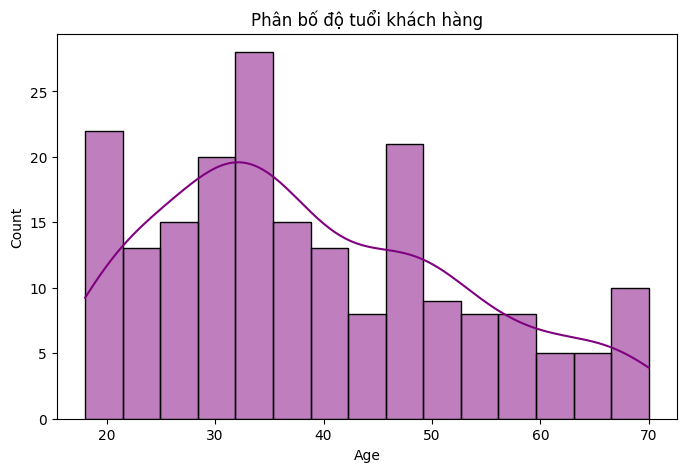

In [76]:
#5
# Vẽ histogram cho độ tuổi
plt.figure(figsize=(8, 5))
sns.histplot(data['Age'], bins=15, kde=True, color='purple')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Phân bố độ tuổi khách hàng')
plt.show()

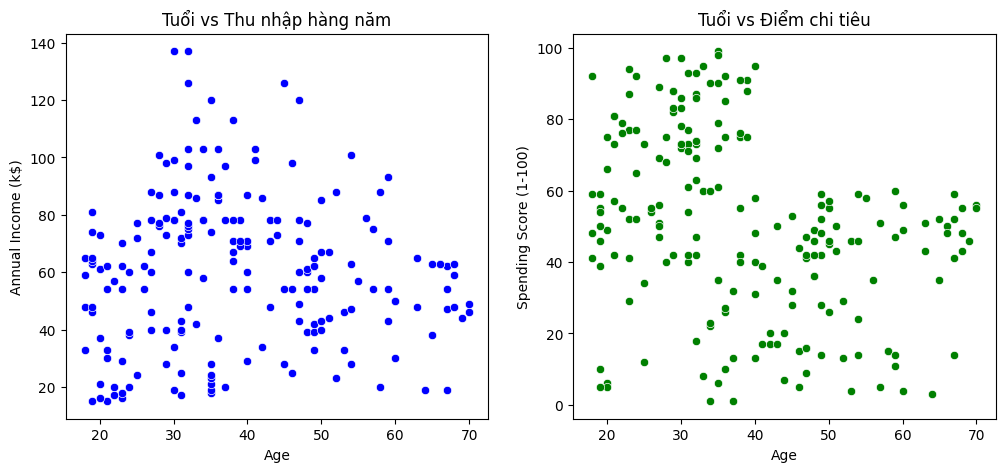

In [77]:
#6
# Vẽ biểu đồ phân tán cho các cặp biến
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=data, color='blue')
plt.title('Tuổi vs Thu nhập hàng năm')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=data, color='green')
plt.title('Tuổi vs Điểm chi tiêu')
plt.show()


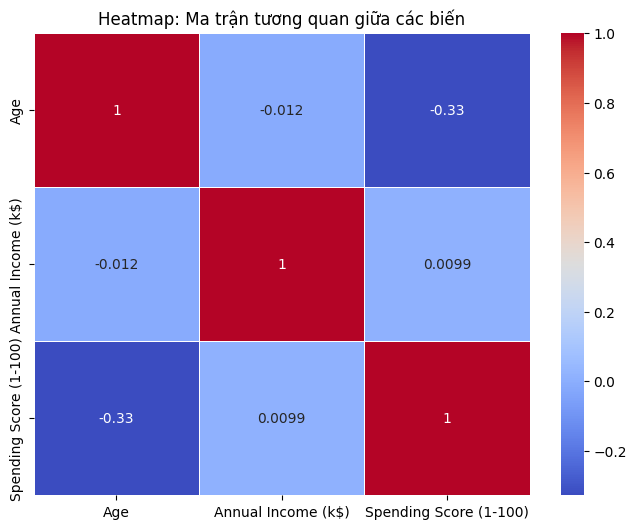

In [78]:
#7
# Heatmap ma trận tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap: Ma trận tương quan giữa các biến")
plt.show()

In [79]:
#8
# Chọn 2 đặc trưng: Age và Spending Score
X = data[["Age", "Spending Score (1-100)"]].values

In [80]:
#9
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [81]:
#10
# 🔹 Hàm khởi tạo K-Means++ để chọn tâm cụm ban đầu ổn định
def kmeans_plus_plus(X, k, random_state=42):
    np.random.seed(random_state)
    centroids = [X[np.random.randint(len(X))]]  # Chọn tâm cụm đầu tiên ngẫu nhiên

    for _ in range(1, k):
        distances = np.min(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2) ** 2, axis=1)
        probs = distances / np.sum(distances)  # Xác suất chọn tâm cụm mới theo khoảng cách | càng xa càng chọn
        new_centroid = X[np.random.choice(len(X), p=probs)]  # Chọn tâm mới
        centroids.append(new_centroid)

    return np.array(centroids)

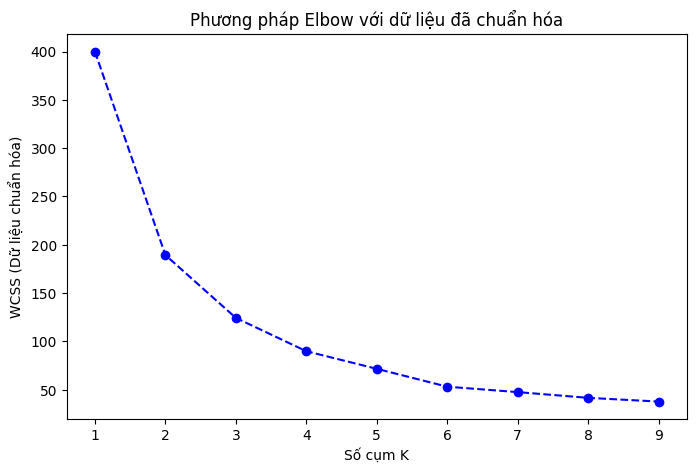

In [82]:
#11
# 🔹 BƯỚC 1: Tìm số cụm K tối ưu bằng phương pháp Elbow
wcss = []
for k in range(1, 10):
    centroids = kmeans_plus_plus(X_scaled, k)  # Dùng K-Means++ để khởi tạo tâm cụm
    for _ in range(100):  # Giới hạn số vòng lặp tối đa để hội tụ
        labels = pairwise_distances_argmin(X_scaled, centroids)

        new_centroids = []
        for j in range(k):
            if np.any(labels == j):  # Kiểm tra nếu cụm có điểm
                new_centroids.append(X_scaled[labels == j].mean(axis=0))
            else:
                new_centroids.append(X_scaled[np.random.randint(len(X_scaled))])  # Chọn ngẫu nhiên từ dữ liệu

        new_centroids = np.array(new_centroids)

        if np.allclose(centroids, new_centroids):  # Kiểm tra hội tụ
            break
        centroids = new_centroids

    # Tính WCSS đúng
    wcss.append(np.sum((X_scaled - centroids[labels]) ** 2))
# 🔹 Vẽ biểu đồ Elbow (Dữ liệu đã chuẩn hóa)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--', color='blue')
plt.xlabel('Số cụm K')
plt.ylabel('WCSS (Dữ liệu chuẩn hóa)')
plt.title('Phương pháp Elbow với dữ liệu đã chuẩn hóa')
plt.show()

In [83]:
#12
# 🔹 BƯỚC 2: Khởi tạo K-Means++ (Giả sử K = 6)
K = 6
np.random.seed(42)
centroids = [X_scaled[np.random.randint(X_scaled.shape[0])]]  # Chọn ngẫu nhiên tâm cụm đầu tiên
# Chọn K-1 tâm cụm còn lại dựa trên khoảng cách
for _ in range(1, K):
    distances = np.min(np.linalg.norm(X_scaled[:, np.newaxis] - centroids, axis=2) ** 2, axis=1)
    probs = distances / np.sum(distances)
    new_centroid = X_scaled[np.random.choice(X_scaled.shape[0], p=probs)]
    centroids.append(new_centroid)
centroids = np.array(centroids)

In [84]:
#13
# 🔹 BƯỚC 3: Chạy K-Means thủ công
max_iter = 100
for _ in range(max_iter):
    labels = pairwise_distances_argmin(X_scaled, centroids)  # Gán điểm vào cụm gần nhất
    new_centroids = np.array([X_scaled[labels == j].mean(axis=0) for j in range(K)])

    # Kiểm tra hội tụ (nếu tâm cụm không thay đổi thì dừng)
    if np.all(centroids == new_centroids):
        break
    centroids = new_centroids

In [85]:
#14
# 🔹 BƯỚC 4: Khử chuẩn hóa (tâm cụm và dữ liệu về dạng ban đầu)
centroids_original = scaler.inverse_transform(centroids)

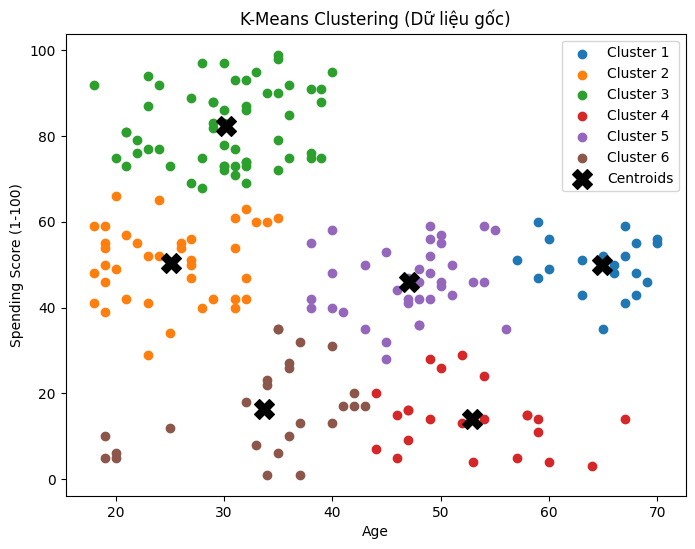

In [86]:
#15
# 🔹 BƯỚC 5: Vẽ kết quả với dữ liệu chưa chuẩn hóa
plt.figure(figsize=(8, 6))
for i in range(K):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")
plt.title("K-Means Clustering (Dữ liệu gốc)")
plt.legend()
plt.show()

In [87]:
#16
# 🔹 BƯỚC 6: Tính Silhouette Score
sil_score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {sil_score:.1f}")

Silhouette Score: 0.5


In [88]:
#17
# 🔹 BƯỚC 7: Tìm cụm khách hàng tiềm năng nhất (Chi tiêu cao nhất)
best_cluster = np.argmax(centroids_original[:, 1])  # Chọn cụm có Spending Score cao nhất
potential_customers = data.iloc[labels == best_cluster]  # Chọn đúng khách hàng từ DataFrame gốc
# Chỉ lấy cột 'Age' và 'Spending Score'
potential_customers_array = potential_customers[["Age", "Spending Score (1-100)"]].to_numpy()
# Tâm cụm và bán kính dựa trên dữ liệu gốc
cluster_center_goc = centroids_original[best_cluster]
cluster_radius = np.max(np.linalg.norm(potential_customers_array - cluster_center_goc, axis=1))

In [89]:
#18
# Chỉ lấy cột 'Age' và 'Spending Score'
potential_customers_array = potential_customers[["Age", "Spending Score (1-100)"]].to_numpy()

In [90]:
#19
# Tâm cụm và bán kính dựa trên dữ liệu gốc
cluster_center_goc = centroids_original[best_cluster]
cluster_radius = np.max(np.linalg.norm(potential_customers_array - cluster_center_goc, axis=1))

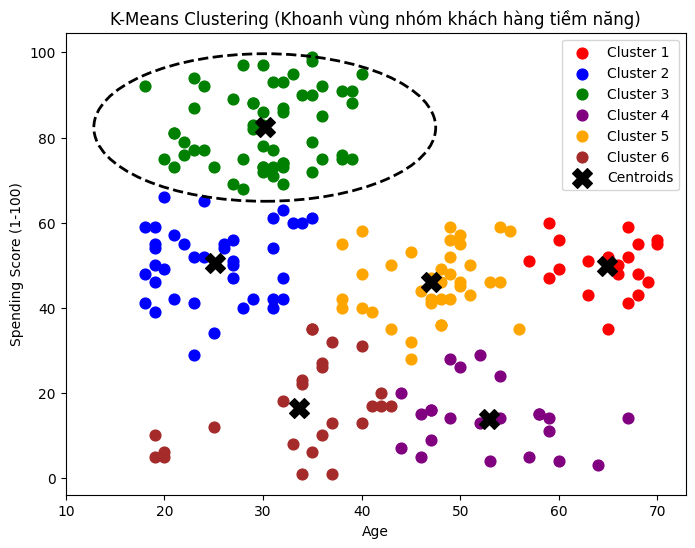

In [91]:
#20
# 🔹 BƯỚC 8: Vẽ kết quả và khoanh tròn cụm tiềm năng
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']
for i in range(K):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], c=colors[i], s=60, label=f'Cluster {i+1}')
# Vẽ hình tròn bao quanh cụm tiềm năng (Dùng cluster_center_goc)
circle = plt.Circle(cluster_center_goc, cluster_radius, color='black', fill=False, linewidth=2, linestyle="dashed")
plt.gca().add_patch(circle)
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")
plt.title("K-Means Clustering (Khoanh vùng nhóm khách hàng tiềm năng)")
plt.legend()
plt.show()

In [92]:
#21 
# 🔹 BƯỚC 9: Thống kê đặc trưng của nhóm khách hàng tiềm năng
print("\n📌 Thống kê về nhóm khách hàng tiềm năng nhất:")
print(potential_customers.describe())

# Hiển thị danh sách khách hàng tiềm năng
print("\n📌 Danh sách khách hàng tiềm năng:")
print(potential_customers)


📌 Thống kê về nhóm khách hàng tiềm năng nhất:
             Age  Annual Income (k$)  Spending Score (1-100)
count  57.000000           57.000000               57.000000
mean   30.175439           66.070175               82.350877
std     5.535995           32.405830                8.913255
min    18.000000           15.000000               68.000000
25%    27.000000           33.000000               75.000000
50%    30.000000           75.000000               81.000000
75%    35.000000           87.000000               90.000000
max    40.000000          137.000000               99.000000

📌 Danh sách khách hàng tiềm năng:
     Gender  Age  Annual Income (k$)  Spending Score (1-100)
1      Male   21                  15                      81
3    Female   23                  16                      77
5    Female   22                  17                      76
7    Female   23                  18                      94
9    Female   30                  19                      72
11 